In [24]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns 
from pylab import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
import pickle
from sklearn.externals import joblib
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")

# classifiers
from sklearn import linear_model 

import os
import logging
%matplotlib inline

# Helper Functions

In [25]:
# This is the data processing pipeline
def preprocessing(data):
    ''' data: the complete file 
     returns: a dataframe with selected features and no missing values '''
    #computing y(preditor variable) 
    y = 0.5*(data["MinTemp"]+data["MaxTemp"])
    data["AvgTemp"] = y
    #reducing dataset only to relavent variables (variables that have a high correlation and are concerned with Temperature)
    df = data[["MinTemp","MaxTemp","Temp9am","Temp3pm","AvgTemp"]]
    # filling in missing values 
    df = df.interpolate()
    return df


In [26]:
#this is a cross validation solution to the problem
def cross_validation_fit(data):
    data = preprocessing(data)
    X = data[["MinTemp","MaxTemp","Temp9am","Temp3pm","AvgTemp"]]
    y= data["AvgTemp"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
    models = {
    "LinearReg": linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(alpha=1.0),
    "Lasso": linear_model.Lasso(alpha=0.1)    
    }
    for model_name,model in models.items():
        cv_results = cross_validate(model, X, y, cv=10,scoring=['r2','neg_mean_squared_error','neg_mean_absolute_error'])
        print("model: ",model_name)
        print("mean fit time: ",cv_results["fit_time"].mean())
        print("mean score time: ",cv_results["score_time"].mean())
        print("mean score r2: ",cv_results["test_r2"].mean())
        print("mean score mean_squared_error: ",-1*cv_results["test_neg_mean_squared_error"].mean())
        print("mean score mean_absolute_error: ",-1*cv_results["test_neg_mean_absolute_error"].mean())
        model_file_path = "C:/Users/DELL/Documents/GitHub/Ml-trail-task/model_site/api/predictor/models/"
        model_file_path=model_file_path + "/" + model_name + ".sav"
        joblib.dump(model,model_file_path)

In [27]:
# this is a 70/30 split solution to the problem
def manual_split_fit(data):
    data = preprocessing(data)
    X = data.iloc[:,0:-1]
    y= data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
    # the list of models applied to the data 
    models = {
    "LinearReg": linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(alpha=1.0),
    "Lasso": linear_model.Lasso(alpha=0.1)    
    }
    for model_name,model in models.items():
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print("model: ",model_name)
        print("the regession equation: {:.2f}x1 + {:.4f}x2 + {:.4f}x3 + {:.4f}x4 + {:.4f}".format(model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3],model.intercept_) )
        print("mean_squared_error: ",metrics.mean_squared_error(y_test,y_pred))
        print("r2 error:",metrics.r2_score(y_test,y_pred))
        model_file_path = "C:/Users/DELL/Documents/GitHub/Ml-trail-task/model_site/api/predictor/models/"
        model_file_path=model_file_path + "/" + model_name + ".sav"
        joblib.dump(model, model_file_path)
        

# Importing data 

In [28]:
data = pd.read_csv("data/weatherAUS.csv")
data = data.set_index(keys=["Location","Date"])
print("dataset shape: ",data.shape)

dataset shape:  (142193, 22)


# Performing Eploratory Data Analysis

## Count of missing values in each column

In [29]:
print(data.isnull().sum())

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64


## Computing predictor variable and checking correlation will other features

<BarContainer object of 18 artists>

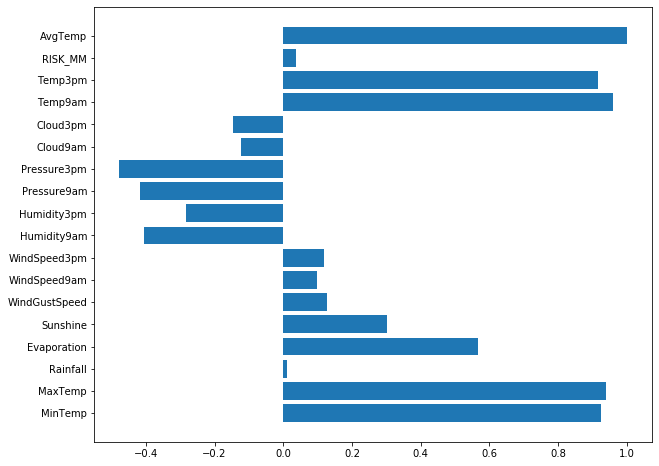

In [30]:
#computing y(preditor variable) 
y = 0.5*(data["MinTemp"]+data["MaxTemp"])
data["AvgTemp"] = y
cor = data.corr()['AvgTemp'][:]
plt.figure(figsize=(10,8))
plt.barh(cor.index,cor)

The bar plot above shows the correlation of AvgTemp with rest of the features<br>
we pick features with correlation more than 0.8

## feature selection and preprocessing data

In [31]:
data1 = preprocessing(data) # pick a highly correlated subset of features from the dataset and fill in null values 
print(data1.isnull().sum())

MinTemp    0
MaxTemp    0
Temp9am    0
Temp3pm    0
AvgTemp    0
dtype: int64


Illustrating distribution of data before and after filling in missing values

comparision of data distributions before an after filling missing values


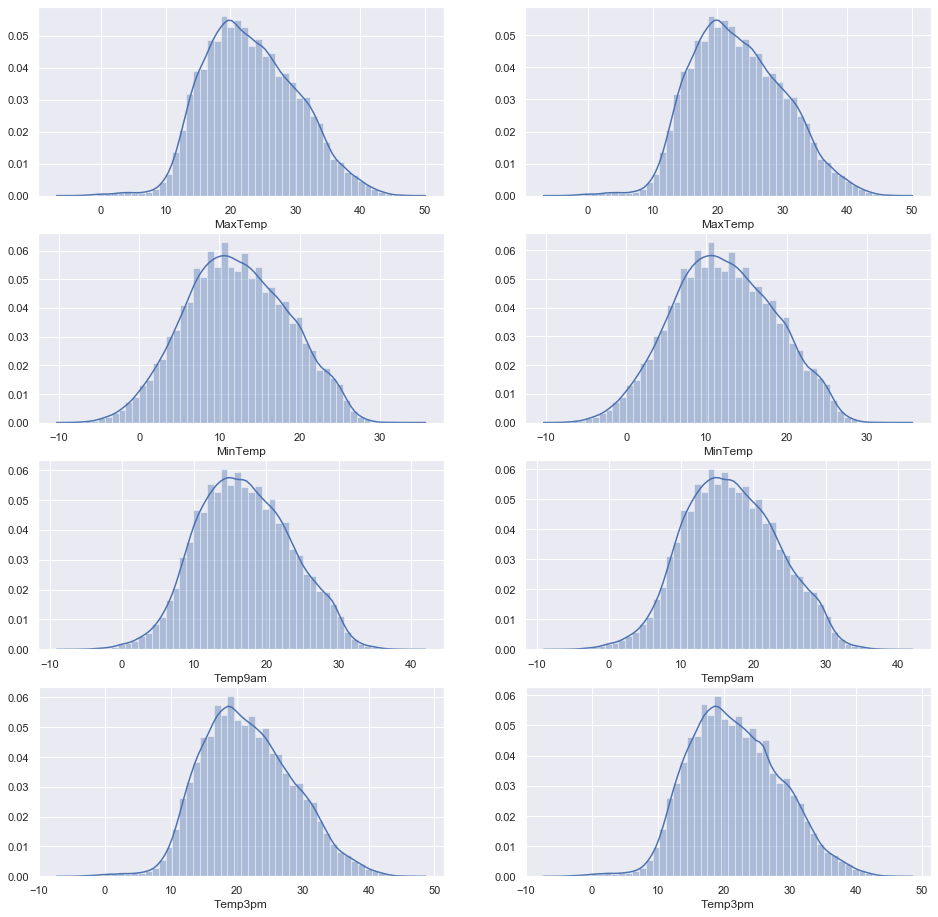

In [32]:
print("comparision of data distributions before an after filling missing values")
sns.set(rc={"figure.figsize": (16, 16)}); 
plt.title("Before vs After")
subplot(4,2,1)
sns.distplot(data['MaxTemp'])
subplot(4,2,3)
sns.distplot(data['MinTemp'])
subplot(4,2,2)
sns.distplot(data1['MaxTemp'])
subplot(4,2,4)
sns.distplot(data1['MinTemp'])
subplot(4,2,5)
sns.distplot(data['Temp9am'])
subplot(4,2,7)
sns.distplot(data['Temp3pm'])
subplot(4,2,6)
sns.distplot(data1['Temp9am'])
subplot(4,2,8)
sns.distplot(data1['Temp3pm'])

As illustrated in the figure above the distribution of data doesn't change after filling in null values.<br>
The rows with null enteries could have been removed but the ratio of null values is very small hence I decided to keep all rows and use interpolate because it linearly fills in values while maintaining the distribution of the data.

In [33]:
corr = data1.corr()
print("correlation among selected features")
print(corr)

correlation among selected features
          MinTemp   MaxTemp   Temp9am   Temp3pm   AvgTemp
MinTemp  1.000000  0.736839  0.902156  0.709671  0.924223
MaxTemp  0.736839  1.000000  0.887788  0.979792  0.938856
Temp9am  0.902156  0.887788  1.000000  0.859329  0.959720
Temp3pm  0.709671  0.979792  0.859329  1.000000  0.913784
AvgTemp  0.924223  0.938856  0.959720  0.913784  1.000000


# The main solution 

In [34]:
manual_split_fit(data)

model:  LinearReg
the regession equation: 0.50x1 + 0.4956x2 + 0.0014x3 + 0.0034x4 + 0.0103
mean_squared_error:  0.013103073945604417
r2 error: 0.9996703046207883
model:  Ridge
the regession equation: 0.50x1 + 0.4956x2 + 0.0014x3 + 0.0034x4 + 0.0103
mean_squared_error:  0.013103072193378982
r2 error: 0.9996703046648772
model:  Lasso
the regession equation: 0.50x1 + 0.4967x2 + 0.0017x3 + 0.0013x4 + 0.0499
mean_squared_error:  0.013380387606771368
r2 error: 0.999663326942645


In [35]:

model_file_path = "C:/Users/DELL/Documents/GitHub/Ml-trail-task/model_site/api/predictor/models/Lasso.sav"
data = pd.read_csv("data/weatherAUS.csv")
data = data.set_index(keys=["Location","Date"])
data = preprocessing(data)
X = data.iloc[:,0:-1]
y= data.iloc[:,-1]
x = np.array(X.iloc[0])
x = x.reshape(1,-1)
print(x.shape)
model = joblib.load(model_file_path)
print(model.predict(x))

(1, 4)
[18.14859732]
